In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import numpy as np
from matplotlib import pyplot as plt

In [85]:
from random_features import RFF

In [86]:
sampler = lambda shape: multivariate_normal(mean=[0]*3, cov=np.eye(3)).rvs(size=np.product(shape))

In [87]:
n_features = 20
assert n_features % 2 == 0
rff = RFF(n_features=n_features // 2, w_sampler=sampler, dim=3)

In [88]:
pts = np.arange(0, 1, 0.1).reshape(-1, 1).repeat(3, axis=1)

In [89]:
features = rff.get_random_features(pts)

In [90]:
assert features.shape == (len(pts), n_features)

In [91]:
from data_utils import Landscape

In [92]:
landscape = Landscape()
landscape.initialize()

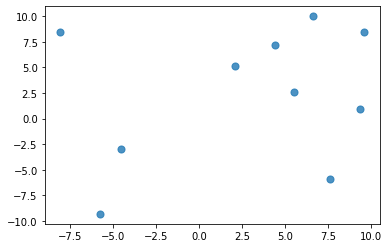

In [93]:
plt.scatter(landscape.landmarks[:, 0], landscape.landmarks[:, 1], s=50, alpha=0.8)

In [94]:
from data_utils import Odometry

N_pts = 100

odometry = Odometry(landscape, observation_dim=3)
odometry.generate(N_pts)

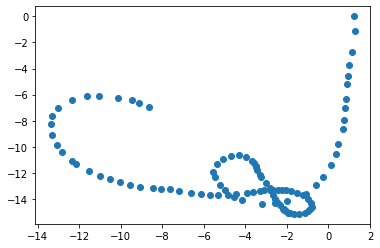

In [95]:
plt.scatter(np.array(odometry.states)[:, 0], np.array(odometry.states)[:, 1])

In [100]:
from model import Model
from observation import RangeModel 
from data_utils import get_prediction


sampler = lambda shape: multivariate_normal(mean=[0], cov=3**2*np.eye(1)).rvs(size=np.product(shape))

n_features = 100
assert n_features % 2 == 0
rff = RFF(n_features=n_features // 2, w_sampler=sampler, dim=1)

initial_values = np.zeros((n_features*3)+2*len(landscape.landmarks))

range_model = RangeModel(odometry.Q[0,0])

def prior_mean(t):
    i = odometry.times.index(t)
    state = get_prediction(odometry.states[i], odometry.motions[i])
    return state


model = Model(rff=rff, 
              initial_values=initial_values,
              times=odometry.times,
              measurements=np.stack(odometry.observations, 0)[:, 0, [0, 2]],
              measurement_covs=[odometry.Q[:1, :1]]*N_pts,
              motions=odometry.motions,
              b_means=np.zeros((n_features*3)+2*len(landscape.landmarks)), #np.zeros((3, n_features)),
              b_covs=[10*np.eye(n_features)]*3,
              land_means=landscape.landmarks,
              land_cov=[10*np.eye(2)]*len(landscape.landmarks),
              observation_model=range_model,
              prior_mean=prior_mean,
              dampening_factor=1e-1
                )

In [101]:
model.run_slam()

14.244663369621923
17.724926809802774
24.862548185134628
31.66928084518451
45.763657174788904
62.3078810417562
95.47564696338557
143.82371406301158
237.0241098263137
412.2594203702905


KeyboardInterrupt: 